# COVID-19

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
URL = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
FMT = '%Y-%m-%dT%H:%M:%S'

def days_to_datetime(days):
    return (datetime(2020, 1, 1) + timedelta(days)).strftime('%Y-%m-%d')

## Logistic model

In [3]:
def logistic_model(x, a, b, c):
    return c/(1+np.exp(-(x-b)/a))

def logistic_model_derivative(x, a, b, c):
    return (c*np.exp((b - x)/a)) / (a * pow((1 + np.exp((b - x)/a)), 2))

## Load and preprocess data


In [4]:
df = pd.read_csv(URL)
df = df[df.codice_regione == 3]
df = df.loc[:,['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi', 'casi_testati']]
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days)

## Trends

In [5]:
x = np.array(df.iloc[:,0])
active_cases = np.array(df.iloc[:,1])
recovered = np.array(df.iloc[:,2])
deaths = np.array(df.iloc[:,3])
total_cases = np.array(df.iloc[:,4])
tested_cases = np.array(df.iloc[:, 5])
delta_active_cases = np.hstack([0, np.ediff1d(active_cases)])
delta_recovered = np.hstack([0, np.ediff1d(recovered)])
delta_deaths = np.hstack([0, np.ediff1d(deaths)])
delta_total_cases = np.hstack([0, np.ediff1d(total_cases)])
delta_tested_cases = np.hstack([np.nan, np.ediff1d(tested_cases)])
ratio = total_cases / tested_cases
delta_ratio = delta_total_cases / delta_tested_cases
print(datetime.now().strftime("%Y-%m-%d %H:%M"))
print()
print(f'Active cases     = {active_cases[-1]}\t(+ {delta_active_cases[-1]})')
print(f'Recovered        = {recovered[-1]}\t(+ {delta_recovered[-1]})')
print(f'Deaths           = {deaths[-1]}\t(+ {delta_deaths[-1]})')
print(f'Total cases      = {total_cases[-1]}\t(+ {delta_total_cases[-1]})')
print(f'Total / Tested   = {ratio[-1] * 100:.2f} %')
print(f'∆total / ∆tested = {delta_ratio[-1] * 100:.2f} %')

2020-06-27 18:00

Active cases     = 10992	(+ -648)
Recovered        = 66046	(+ 723)
Deaths           = 16626	(+ 2)
Total cases      = 93664	(+ 77)
Total / Tested   = 15.44 %
∆total / ∆tested = 1.37 %


/Users/fabio/dev/Python/covid19/python/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


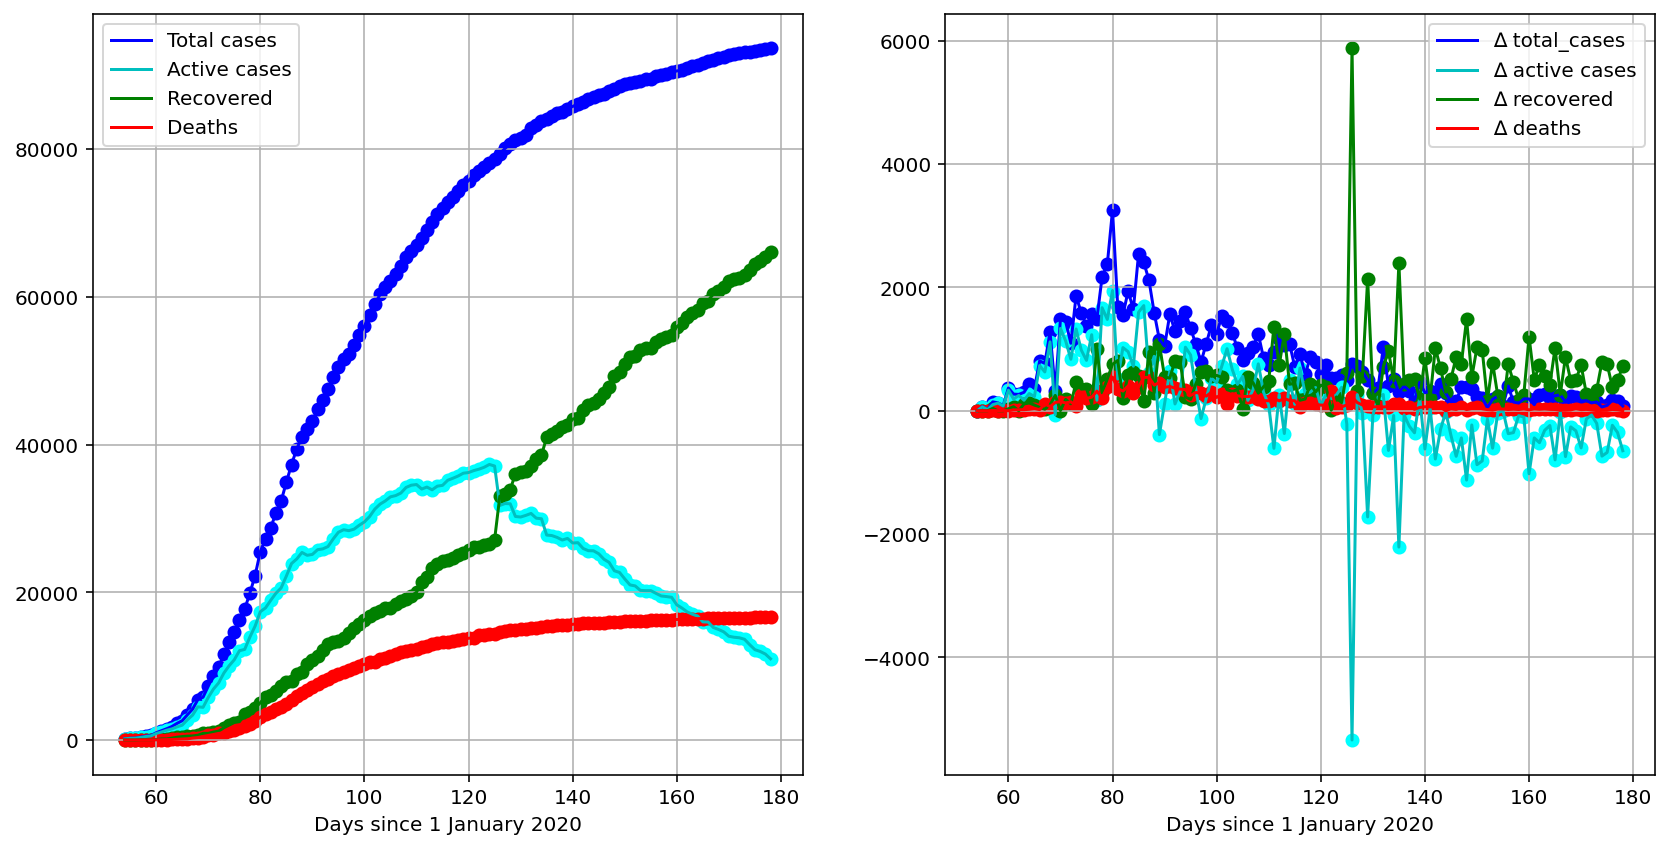

In [6]:
plt.rcParams['figure.figsize'] = [14, 7]
plt.subplot(1, 2, 1)
plt.scatter(x, total_cases, color='blue')
plt.plot(x, total_cases, 'b', label='Total cases')
plt.scatter(x, active_cases, color='cyan')
plt.plot(x, active_cases, 'c', label='Active cases')
plt.scatter(x, recovered, color='green')
plt.plot(x, recovered, 'g', label='Recovered')
plt.scatter(x, deaths, color='red')
plt.plot(x, deaths, 'r', label='Deaths')
plt.xlabel('Days since 1 January 2020')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(x, delta_total_cases, color='blue')
plt.plot(x, delta_total_cases, 'b', label='∆ total_cases')
plt.scatter(x, delta_active_cases, color='cyan')
plt.plot(x, delta_active_cases, 'c', label='∆ active cases')
plt.scatter(x, delta_recovered, color='green')
plt.plot(x, delta_recovered, 'g', label='∆ recovered')
plt.scatter(x, delta_deaths, color='red')
plt.plot(x, delta_deaths, 'r', label='∆ deaths')
plt.xlabel('Days since 1 January 2020')
plt.legend()
plt.grid(True)

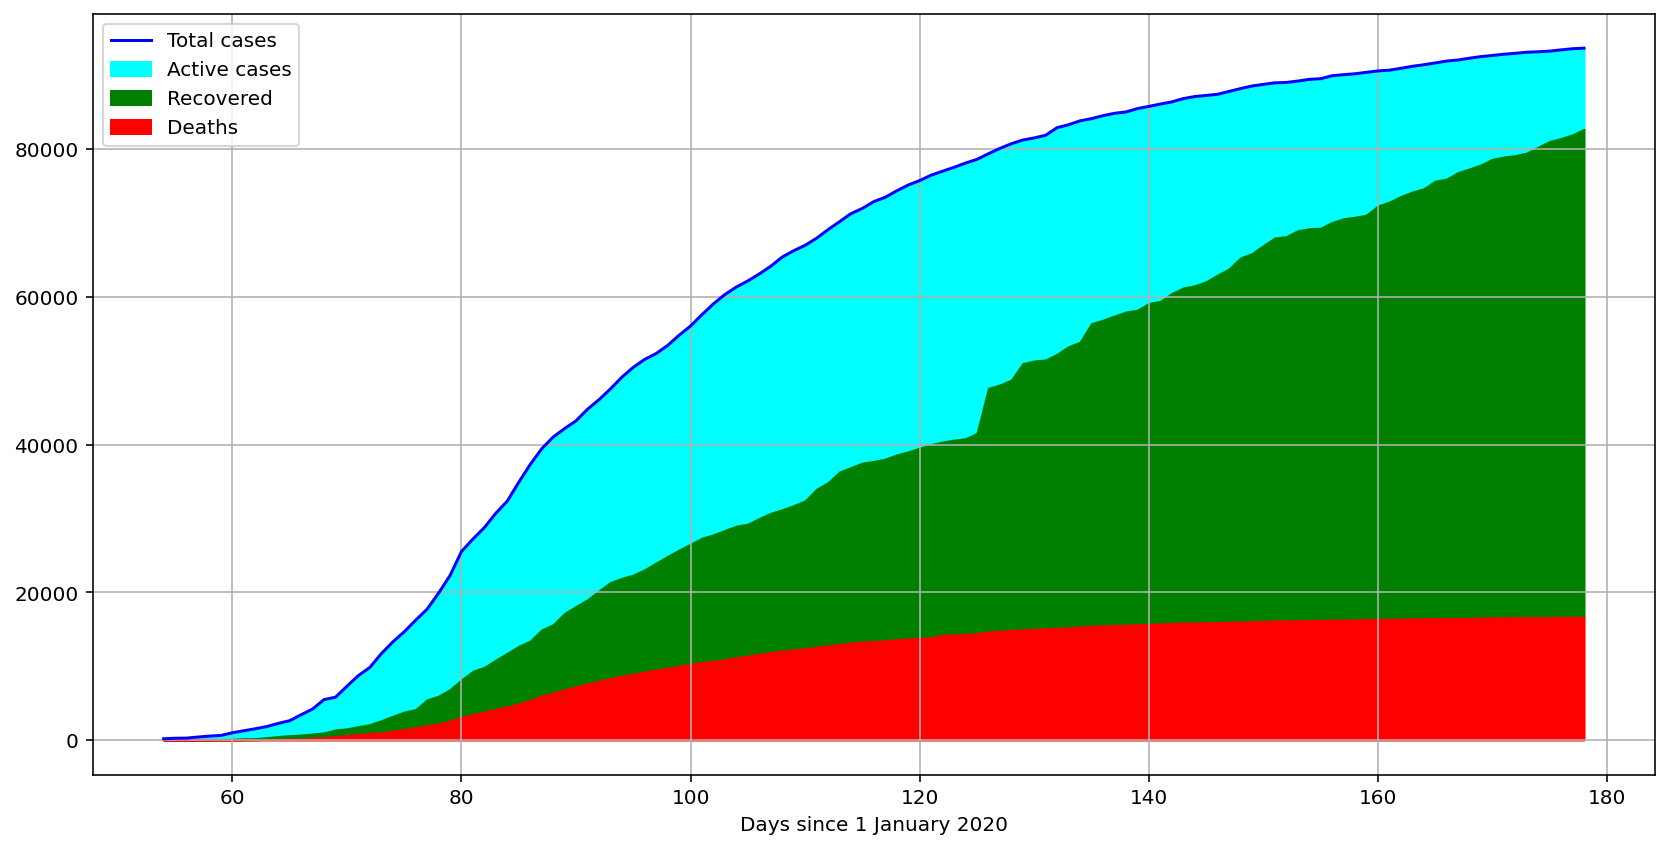

In [7]:
plt.fill_between(x, deaths+recovered, deaths+recovered+active_cases, color='cyan', label='Active cases')
plt.fill_between(x, deaths, deaths+recovered, color='green', label='Recovered')
plt.fill_between(x, deaths, color='red', label='Deaths')
plt.plot(x, total_cases, 'b', label='Total cases')
plt.xlabel('Days since 1 January 2020')
plt.legend()
plt.grid(True)

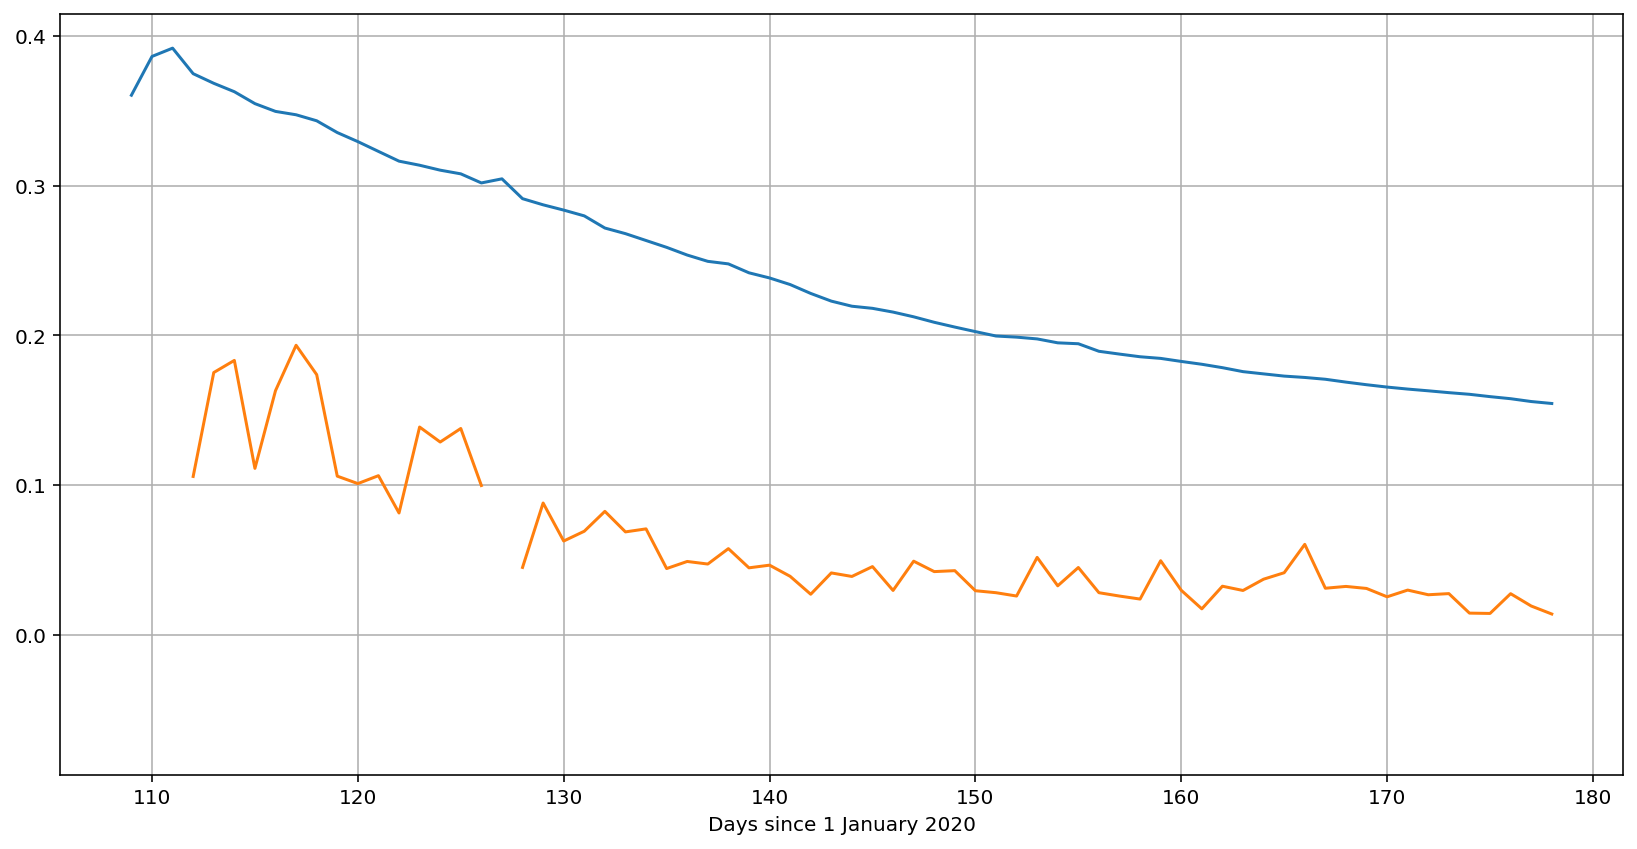

In [8]:
plt.plot(x, ratio, label='Ratio')
plt.plot(x, delta_ratio, label='∆ Ratio')
plt.xlabel('Days since 1 January 2020')
plt.grid(True)

## Fit logistic model on total cases

In [9]:
fit = curve_fit(logistic_model, x, total_cases, p0=[4, 100, 50000])
a, b, c = fit[0]
_, err_b, err_c = (np.sqrt(fit[1][i][i]) for i in [0, 1, 2])
sol = fsolve(lambda x : logistic_model(x, a, b, c) - int(c), b)[0]
print(f'Expected number of infected people = {c:.2f} ± {int(np.ceil(err_c))}')
print(f'Expected infection peak = {days_to_datetime(b)} ± {int(np.ceil(err_b))} days')
print(f'Expected infection end = {days_to_datetime(sol)}')

Expected number of infected people = 89779.47 ± 545
Expected infection peak = 2020-04-03 ± 1 days
Expected infection end = 2020-09-10


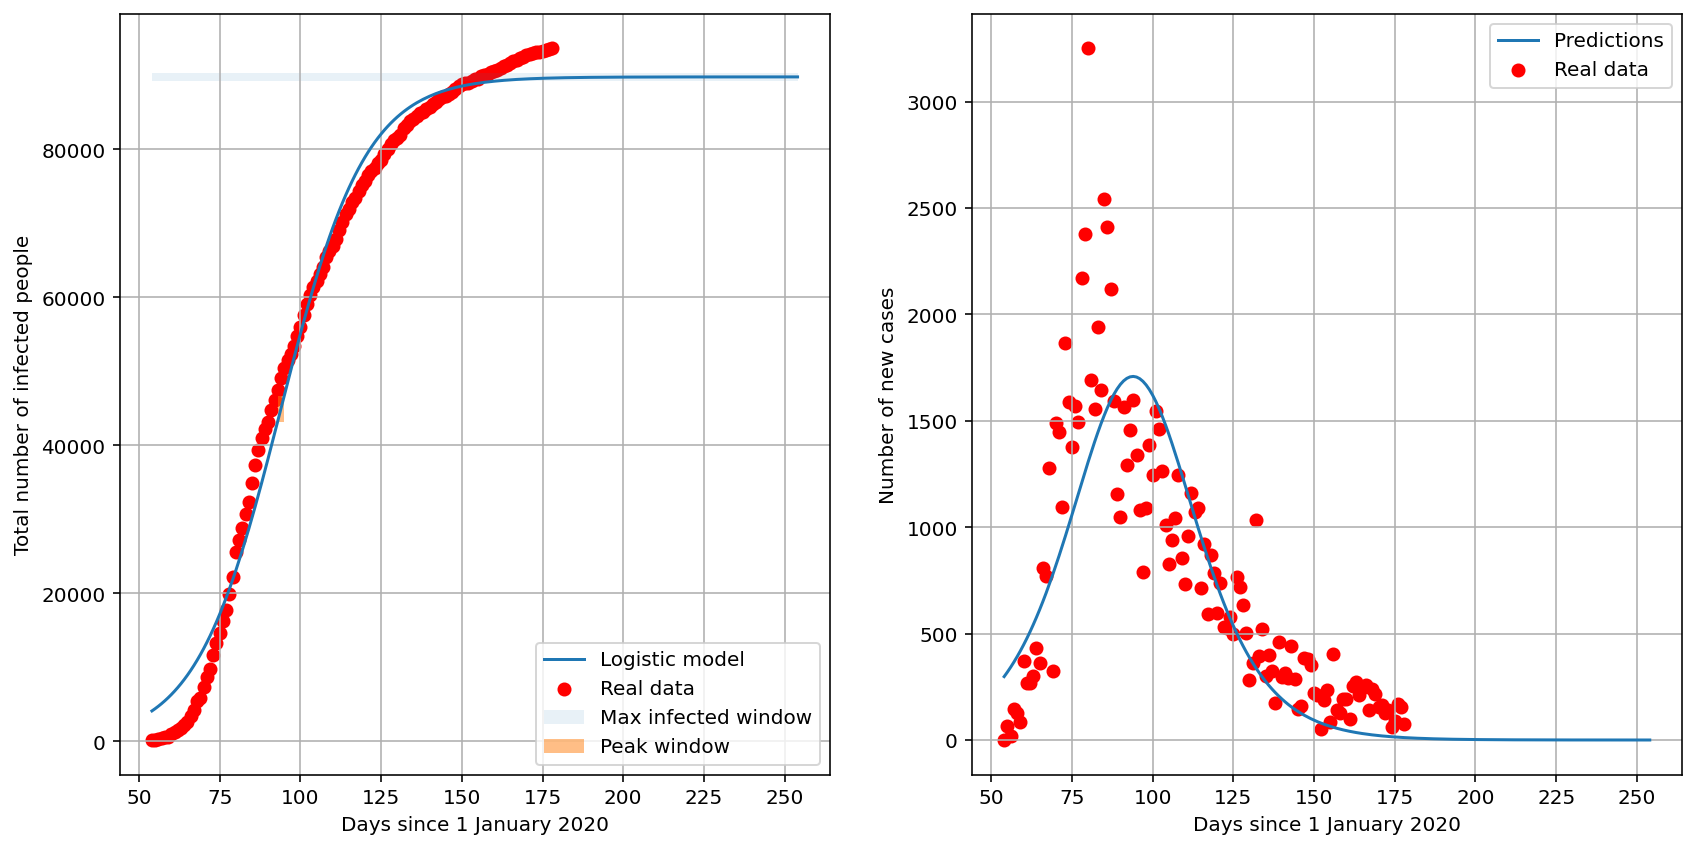

In [10]:
pred_x = np.arange(x.min(), sol+1)
pred_total_cases = logistic_model(pred_x, a, b, c)
plt.subplot(1, 2, 1)
plt.scatter(x, total_cases, label='Real data', color='red')
plt.plot(pred_x, pred_total_cases, label='Logistic model')
plt.fill_between(pred_x, c - err_c, c + err_c, alpha=0.1, label='Max infected window')
plt.fill_between([b - np.ceil(err_b), b + np.ceil(err_b)], 
                 logistic_model(b - np.ceil(err_b), a, b, c),
                 logistic_model(b + np.ceil(err_b), a, b, c),
                 alpha=0.5, label='Peak window')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Total number of infected people')
plt.legend()
plt.grid(True)

pred_new_cases = logistic_model_derivative(pred_x, a, b, c)
plt.subplot(1, 2, 2)
plt.scatter(x, delta_total_cases, label='Real data', color='red')
plt.plot(pred_x, pred_new_cases, label='Predictions')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Number of new cases')
plt.legend()
plt.grid(True)

## Fit derivative of logistic model with new cases

In [11]:
fit = curve_fit(logistic_model_derivative, x, delta_total_cases, p0=[4, 100, 50000])
a, b, c = fit[0]
_, err_b, err_c = (np.sqrt(fit[1][i][i]) for i in [0, 1, 2])
sol = int(fsolve(lambda x : logistic_model(x, a, b, c) - int(c), b)[0])
print(f'Expected number of infected people = {c:.2f} ± {int(np.ceil(err_c))}')
print(f'Expected infection peak = {days_to_datetime(b)} ± {int(np.ceil(err_b))} days')
print(f'Expected infection end = {days_to_datetime(sol)}')

Expected number of infected people = 94184.43 ± 4396
Expected infection peak = 2020-03-29 ± 2 days
Expected infection end = 2020-09-13


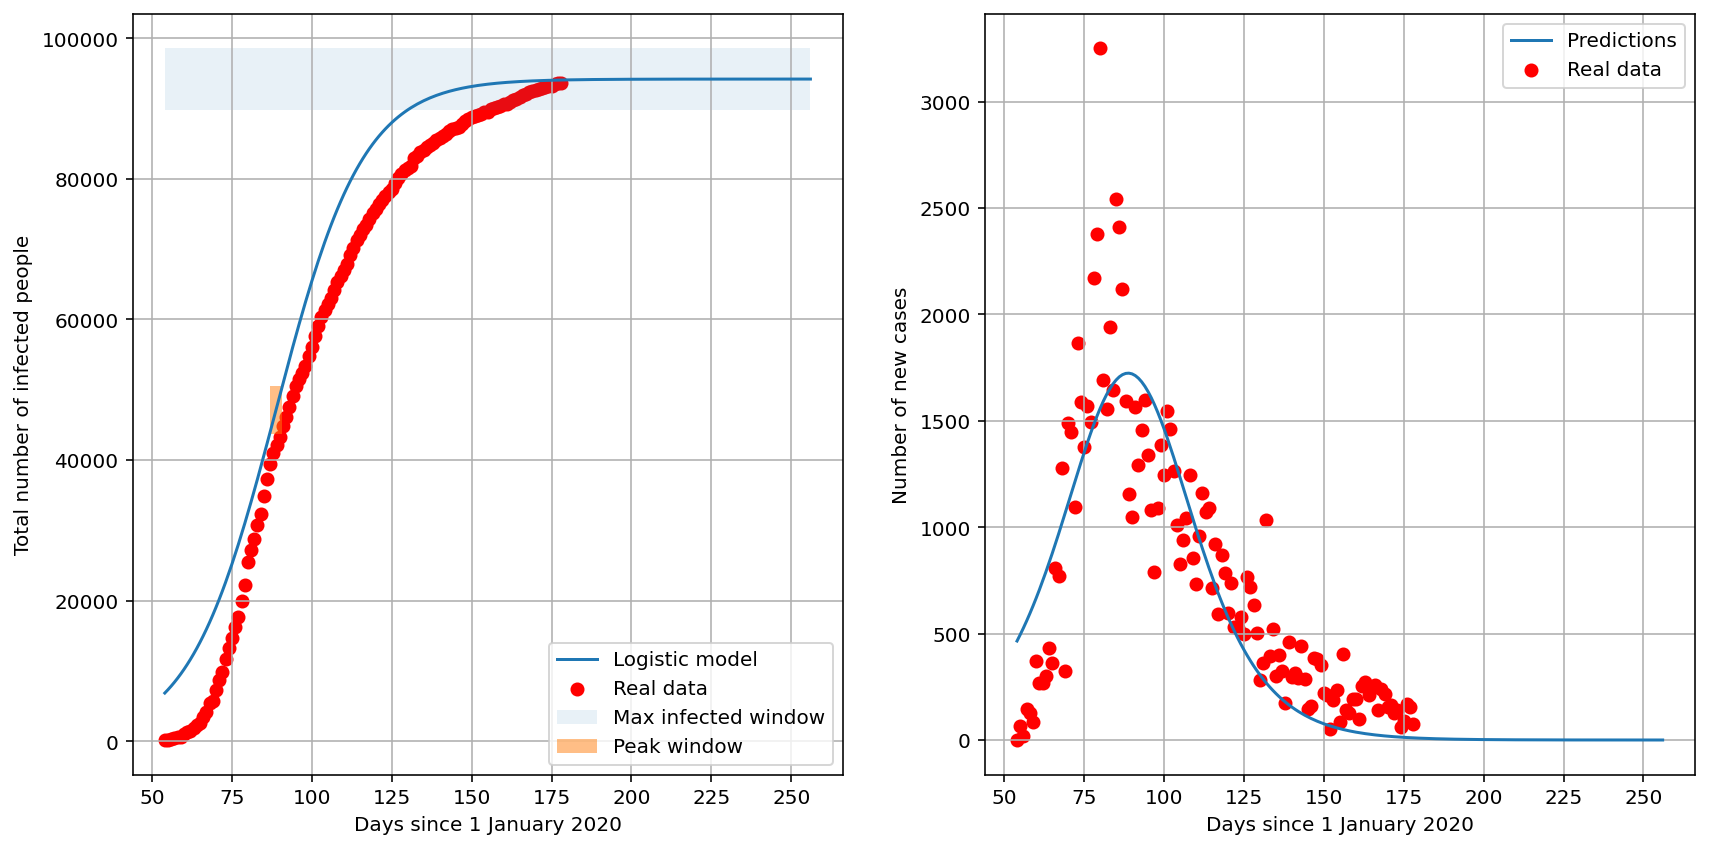

In [12]:
pred_x = np.arange(x.min(), sol+1)
pred_total_cases = logistic_model(pred_x, a, b, c)
plt.subplot(1, 2, 1)
plt.scatter(x, total_cases, label='Real data', color='red')
plt.plot(pred_x, pred_total_cases, label='Logistic model')
plt.fill_between(pred_x, c - err_c, c + err_c, alpha=0.1, label='Max infected window')
plt.fill_between([b - np.ceil(err_b), b + np.ceil(err_b)], 
                 logistic_model(b - np.ceil(err_b), a, b, c),
                 logistic_model(b + np.ceil(err_b), a, b, c),
                 alpha=0.5, label='Peak window')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Total number of infected people')
plt.legend()
plt.grid(True)

pred_new_cases = logistic_model_derivative(pred_x, a, b, c)
plt.subplot(1, 2, 2)
plt.scatter(x, delta_total_cases, label='Real data', color='red')
plt.plot(pred_x, pred_new_cases, label='Predictions')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Number of new cases')
plt.legend()
plt.grid(True)

## Fit both curves simultaneously

In [13]:
DATA_SIZE = len(x)

def f(x, a, b, c):
    x1 = x[0:DATA_SIZE]
    x2 = x[DATA_SIZE:]
    y1 = logistic_model(x1, a, b, c)
    y2 = logistic_model_derivative(x2, a, b, c)
    return np.hstack([y1, y2])

fit = curve_fit(f, np.hstack([x, x]), np.hstack([total_cases, delta_total_cases]), p0=[4, 100, 50000])
a, b, c = fit[0]
_, err_b, err_c = (np.sqrt(fit[1][i][i]) for i in [0, 1, 2])
sol = int(fsolve(lambda x : logistic_model(x, a, b, c) - int(c), b)[0])
print(f'Expected number of infected people = {c:.2f} ± {int(np.ceil(err_c))}')
print(f'Expected infection peak = {days_to_datetime(b)} ± {int(np.ceil(err_b))} days')
print(f'Expected infection end = {days_to_datetime(sol)}')

Expected number of infected people = 89776.23 ± 385
Expected infection peak = 2020-04-03 ± 1 days
Expected infection end = 2020-09-20
